# Capstone - Port Hardy Data Cleaning and EDA
Date Started: 2021.10.28<br>
Date Completed: 2021...<br>
William Matthews

### Data Set

### Data Dictionary

### Report Objectives and Flow

This report's primary objective is to outline the data cleaning process for the Port Hardy Weather Ballon Station Data.  The rough plan is as follows:
- Confirm we have the appropriate dates
- Identify any rows with missing data
    - Shift data to correct columns if possible (the scraping process was not perfect!)
    - If missing data is in columns of interest, explore dropping or imputing
        - Drop/impute as needed
- Drop columns that are not of interest
- Check for duplicates and drop as neccessary
- Compress multiple soundings for a specific datetime into some sort of aggregated measure
- Do EDA on our cleaned data
- Write to csv

### Libraries and Imports

In [1]:
# managing data
import pandas as pd
import numpy as np

# managing time
from datetime import datetime
from datetime import timedelta

# plotting data
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for timeseries EDA
from statsmodels.api import tsa
import statsmodels.api as sm

In [2]:
ph_df = pd.read_csv('./Data/BallonData/Port Hardy.csv')

### Data Exploration

Let's start out with a high level look at our data.

In [3]:
display(ph_df.info(),
        ph_df.head(),
        ph_df.shape,
        ph_df.isna().sum().sum() / ph_df.shape[0]) # calculate % of rows with NaN values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8838 entries, 0 to 8837
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    8838 non-null   object 
 1   PRES    8838 non-null   float64
 2   HGHT    8838 non-null   int64  
 3   TEMP    8838 non-null   float64
 4   DWPT    8838 non-null   float64
 5   RELH    8838 non-null   int64  
 6   MIXR    8838 non-null   float64
 7   DRCT    8838 non-null   float64
 8   SKNT    8827 non-null   float64
 9   THTA    8827 non-null   float64
 10  THTE    8813 non-null   float64
 11  THTV    8813 non-null   float64
 12  STNM    8838 non-null   object 
dtypes: float64(9), int64(2), object(2)
memory usage: 897.7+ KB


None

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0  2014-12-31 16:00:00  724.0  2899  -1.7  -5.3    76  3.58  351.0  25.0   
1  2014-12-31 16:00:00  714.0  3010  -1.9  -6.6    70  3.28  344.0  25.0   
2  2014-12-31 16:00:00  703.0  3134  -1.1 -10.1    50  2.54  337.0  26.0   
3  2014-12-31 16:00:00  700.0  3168  -1.3 -11.3    47  2.31  335.0  26.0   
4  2014-12-31 16:00:00  699.0  3179  -1.3 -11.3    47  2.32  333.0  26.0   

    THTA   THTE   THTV        STNM  
0  297.7  308.6  298.3  Port Hardy  
1  298.7  308.8  299.2  Port Hardy  
2  300.9  308.9  301.3  Port Hardy  
3  301.0  308.4  301.4  Port Hardy  
4  301.1  308.5  301.6  Port Hardy

(8838, 13)

0.008146639511201629

From the above it look like we have 8,838 rows across 13 columns.  Several columns have some missing values, but calculated by rows, this accounts for less than 1% of our data.  We will address this shortly.  The data appears to be what is expected based on the first 5 rows.  Data types are all as expected.  Since we might do some manipulation on the `DATE` column, we will change it to a date time.  We will do a quick check to make sure the first and last dates match our known date range first (01 Jan 2015 through 17 Apr 2021).

In [4]:
print(f"First Date: {ph_df.iloc[0, :]['DATE']}")
print(f"Last Date: {ph_df.iloc[-1, :]['DATE']}")

First Date: 2014-12-31 16:00:00
Last Date: 2021-04-30 04:00:00


From the above it looks like the first date matches our expectations (the night before our first target date).  The ending date is a little past our ending date of 17 Apr 2021.  Let's go ahead and convert the column to datetime and then drop the records that are later than 17 Apr 2021.

In [5]:
# convert column to date time
ph_df['DATE'] = pd.to_datetime(ph_df['DATE'] )

# confirm it worked
ph_df['DATE'].dtypes

dtype('<M8[ns]')

Now that we have the `DATE` column as datetime objects, let's move ahead and drop the records outside our time range

In [6]:
# get the indicies of rows with dates past our last date
past_indicies = ph_df[ph_df['DATE'] > datetime(2021, 4, 17)].index

# confirm this drop is going to do what we want it to by checking the max date after drop
(ph_df.drop(index = past_indicies)['DATE'].max() < datetime(2021, 4, 18))

True

In [7]:
# drop the additional rows
ph_df1 = ph_df.drop(index = past_indicies).copy()

# confirm
display(ph_df1['DATE'].max() < datetime(2021, 4, 18))

# double check
display(ph_df1.iloc[-1, :])

True

DATE    2021-04-16 16:00:00
PRES                  682.4
HGHT                   3353
TEMP                   -1.2
DWPT                  -18.2
RELH                     26
MIXR                   1.34
DRCT                   95.0
SKNT                   13.0
THTA                  303.4
THTE                  307.8
THTV                  303.6
STNM             Port Hardy
Name: 8763, dtype: object

### Data Exploration - Column Shifting

With the data outside of our time range removed let's move onto the rows with missing values.  We know that when we scraped the data from the website that a few records were missing various columns.  The scraping algorithem dealt with this by simply shifting all values to the left most empty columns.  Let's take a look at all of the rows missing data (only 25) to make sure nothing strange is going on.  We will also bring up a few rows of good data for comparison.

In [8]:
display(ph_df1[ph_df1.isna().any(axis = 1)])
display(ph_df1.head())

DATE   PRES  HGHT  TEMP   DWPT  RELH    MIXR   DRCT  \
488  2015-02-25 04:00:00  704.2  3048  -5.0  265.0    15  296.40  296.4   
489  2015-02-25 04:00:00  700.0  3095  -5.3  275.0    14  296.60  296.6   
490  2015-02-25 04:00:00  698.0  3117  -5.5  276.0    15  296.60  296.6   
491  2015-02-25 04:00:00  677.2  3353  -6.3  285.0    23  298.30  298.3   
2451 2016-11-08 16:00:00  720.9  2743  -1.3  190.0    45  298.50  298.5   
2452 2016-11-08 16:00:00  700.0  2978  -2.3  185.0    50  299.90  299.9   
2453 2016-11-08 16:00:00  693.8  3048  -2.7  185.0    48  300.30  300.3   
2666 2016-12-01 16:00:00  700.0  3003  -9.3  -34.3    11    0.30  292.2   
2851 2016-12-26 16:00:00  715.0  2712  -9.3   -9.3   100    2.66  290.4   
2852 2016-12-26 16:00:00  703.0  2843 -11.3  -11.9    95    2.20  289.6   
2853 2016-12-26 16:00:00  688.0  3007 -13.9  -26.9    32    0.62  288.5   
2854 2016-12-26 16:00:00  686.0  3029 -14.1  -26.1    36    0.67  288.5   
2855 2016-12-26 16:00:00  676.0  3141 -14.5  -24.5    42    0.78  289.3   
3539 2017-03-18 04:00:00  724.0  2567 -13.3  -13.5    98    1.87  285.0   
3540 2017-03-18 04:00:00  700.0  2823 -14.9  -15.1    98    1.70  286.0   
3541 2017-03-18 04:00:00  672.0  3132 -16.5  -17.0    96    1.51  287.5   
3700 2017-04-04 16:00:00  712.8  2743  -2.8  180.0    54  297.80  297.8   
3701 2017-04-04 16:00:00  700.0  2886  -3.1  185.0    60  299.00  299.0   
3702 2017-04-04 16:00:00  693.0  2965  -3.3  190.0    56  299.70  299.7   
3703 2017-04-04 16:00:00  685.7  3048  -3.7  195.0    52  300.10  300.1   
5462 2018-11-01 16:00:00  683.0  3195  -0.7   -0.7   100    5.35  303.8   
6076 2019-02-01 04:00:00  707.0  2750  -7.7   -9.4    88    2.66  293.1   
6314 2019-03-10 16:00:00  689.0  3113 -10.1  -12.2    85    2.19  292.6   
6315 2019-03-10 16:00:00  685.0  3156  -9.7  -11.7    85    2.29  293.5   
6424 2019-03-29 04:00:00  698.0  3093 -10.5  -14.8    71    1.75  291.1   

       SKNT   THTA  THTE  THTV        STNM  
488     NaN    NaN   NaN   NaN  Port Hardy  
489     NaN    NaN   NaN   NaN  Port Hardy  
490     NaN    NaN   NaN   NaN  Port Hardy  
491     NaN    NaN   NaN   NaN  Port Hardy  
2451    NaN    NaN   NaN   NaN  Port Hardy  
2452    NaN    NaN   NaN   NaN  Port Hardy  
2453    NaN    NaN   NaN   NaN  Port Hardy  
2666  293.2  292.2   NaN   NaN  Port Hardy  
2851  298.4  290.9   NaN   NaN  Port Hardy  
2852  296.3  290.0   NaN   NaN  Port Hardy  
2853  290.5  288.6   NaN   NaN  Port Hardy  
2854  290.7  288.6   NaN   NaN  Port Hardy  
2855  291.8  289.4   NaN   NaN  Port Hardy  
3539  290.6  285.3   NaN   NaN  Port Hardy  
3540  291.1  286.2   NaN   NaN  Port Hardy  
3541  292.2  287.8   NaN   NaN  Port Hardy  
3700    NaN    NaN   NaN   NaN  Port Hardy  
3701    NaN    NaN   NaN   NaN  Port Hardy  
3702    NaN    NaN   NaN   NaN  Port Hardy  
3703    NaN    NaN   NaN   NaN  Port Hardy  
5462  320.3  304.8   NaN   NaN  Port Hardy  
6076  301.2  293.6   NaN   NaN  Port Hardy  
6314  299.3  293.0   NaN   NaN  Port Hardy  
6315  300.6  293.9   NaN   NaN  Port Hardy  
6424  296.5  291.4   NaN   NaN  Port Hardy

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0 2014-12-31 16:00:00  724.0  2899  -1.7  -5.3    76  3.58  351.0  25.0   
1 2014-12-31 16:00:00  714.0  3010  -1.9  -6.6    70  3.28  344.0  25.0   
2 2014-12-31 16:00:00  703.0  3134  -1.1 -10.1    50  2.54  337.0  26.0   
3 2014-12-31 16:00:00  700.0  3168  -1.3 -11.3    47  2.31  335.0  26.0   
4 2014-12-31 16:00:00  699.0  3179  -1.3 -11.3    47  2.32  333.0  26.0   

    THTA   THTE   THTV        STNM  
0  297.7  308.6  298.3  Port Hardy  
1  298.7  308.8  299.2  Port Hardy  
2  300.9  308.9  301.3  Port Hardy  
3  301.0  308.4  301.4  Port Hardy  
4  301.1  308.5  301.6  Port Hardy

Two of the key variables of interst are `DRCT` (wind direction) and `SKNT` (speed in knots) so it is unfortunate they have been effected.  `THTA, THTE,` and `THTV` are not of interest to us, so we are not worried about them.  The trouble with simply deleting these records is that we only have two times of measurement per day, and relatively few soundings for each datetime, so simply deleting them will leave holes in our record.  Let's grab each unique datetime and then see if we can impute the values.  This may take some manual research to get the sounding data we omitted from our webscraping!

First thing to do is get all the NaN records into a smaller data frame to work with.  We will deal with each date one by one.

_Personal Note: Roughlyl 1 hr to this point_

In [9]:
# get nan records
nans_df = ph_df1[ph_df1.isna().any(axis = 1)]

# confirm it worked
nans_df

DATE   PRES  HGHT  TEMP   DWPT  RELH    MIXR   DRCT  \
488  2015-02-25 04:00:00  704.2  3048  -5.0  265.0    15  296.40  296.4   
489  2015-02-25 04:00:00  700.0  3095  -5.3  275.0    14  296.60  296.6   
490  2015-02-25 04:00:00  698.0  3117  -5.5  276.0    15  296.60  296.6   
491  2015-02-25 04:00:00  677.2  3353  -6.3  285.0    23  298.30  298.3   
2451 2016-11-08 16:00:00  720.9  2743  -1.3  190.0    45  298.50  298.5   
2452 2016-11-08 16:00:00  700.0  2978  -2.3  185.0    50  299.90  299.9   
2453 2016-11-08 16:00:00  693.8  3048  -2.7  185.0    48  300.30  300.3   
2666 2016-12-01 16:00:00  700.0  3003  -9.3  -34.3    11    0.30  292.2   
2851 2016-12-26 16:00:00  715.0  2712  -9.3   -9.3   100    2.66  290.4   
2852 2016-12-26 16:00:00  703.0  2843 -11.3  -11.9    95    2.20  289.6   
2853 2016-12-26 16:00:00  688.0  3007 -13.9  -26.9    32    0.62  288.5   
2854 2016-12-26 16:00:00  686.0  3029 -14.1  -26.1    36    0.67  288.5   
2855 2016-12-26 16:00:00  676.0  3141 -14.5  -24.5    42    0.78  289.3   
3539 2017-03-18 04:00:00  724.0  2567 -13.3  -13.5    98    1.87  285.0   
3540 2017-03-18 04:00:00  700.0  2823 -14.9  -15.1    98    1.70  286.0   
3541 2017-03-18 04:00:00  672.0  3132 -16.5  -17.0    96    1.51  287.5   
3700 2017-04-04 16:00:00  712.8  2743  -2.8  180.0    54  297.80  297.8   
3701 2017-04-04 16:00:00  700.0  2886  -3.1  185.0    60  299.00  299.0   
3702 2017-04-04 16:00:00  693.0  2965  -3.3  190.0    56  299.70  299.7   
3703 2017-04-04 16:00:00  685.7  3048  -3.7  195.0    52  300.10  300.1   
5462 2018-11-01 16:00:00  683.0  3195  -0.7   -0.7   100    5.35  303.8   
6076 2019-02-01 04:00:00  707.0  2750  -7.7   -9.4    88    2.66  293.1   
6314 2019-03-10 16:00:00  689.0  3113 -10.1  -12.2    85    2.19  292.6   
6315 2019-03-10 16:00:00  685.0  3156  -9.7  -11.7    85    2.29  293.5   
6424 2019-03-29 04:00:00  698.0  3093 -10.5  -14.8    71    1.75  291.1   

       SKNT   THTA  THTE  THTV        STNM  
488     NaN    NaN   NaN   NaN  Port Hardy  
489     NaN    NaN   NaN   NaN  Port Hardy  
490     NaN    NaN   NaN   NaN  Port Hardy  
491     NaN    NaN   NaN   NaN  Port Hardy  
2451    NaN    NaN   NaN   NaN  Port Hardy  
2452    NaN    NaN   NaN   NaN  Port Hardy  
2453    NaN    NaN   NaN   NaN  Port Hardy  
2666  293.2  292.2   NaN   NaN  Port Hardy  
2851  298.4  290.9   NaN   NaN  Port Hardy  
2852  296.3  290.0   NaN   NaN  Port Hardy  
2853  290.5  288.6   NaN   NaN  Port Hardy  
2854  290.7  288.6   NaN   NaN  Port Hardy  
2855  291.8  289.4   NaN   NaN  Port Hardy  
3539  290.6  285.3   NaN   NaN  Port Hardy  
3540  291.1  286.2   NaN   NaN  Port Hardy  
3541  292.2  287.8   NaN   NaN  Port Hardy  
3700    NaN    NaN   NaN   NaN  Port Hardy  
3701    NaN    NaN   NaN   NaN  Port Hardy  
3702    NaN    NaN   NaN   NaN  Port Hardy  
3703    NaN    NaN   NaN   NaN  Port Hardy  
5462  320.3  304.8   NaN   NaN  Port Hardy  
6076  301.2  293.6   NaN   NaN  Port Hardy  
6314  299.3  293.0   NaN   NaN  Port Hardy  
6315  300.6  293.9   NaN   NaN  Port Hardy  
6424  296.5  291.4   NaN   NaN  Port Hardy

In [10]:
# show the first date only vs the good data
print("Bad Data")
display(nans_df[nans_df['DATE'] == datetime(2015, 2, 25, 4)])
print()
print("Good Data")
display(ph_df1.head())

Bad Data


DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR   DRCT  SKNT  \
488 2015-02-25 04:00:00  704.2  3048  -5.0  265.0    15  296.4  296.4   NaN   
489 2015-02-25 04:00:00  700.0  3095  -5.3  275.0    14  296.6  296.6   NaN   
490 2015-02-25 04:00:00  698.0  3117  -5.5  276.0    15  296.6  296.6   NaN   
491 2015-02-25 04:00:00  677.2  3353  -6.3  285.0    23  298.3  298.3   NaN   

     THTA  THTE  THTV        STNM  
488   NaN   NaN   NaN  Port Hardy  
489   NaN   NaN   NaN  Port Hardy  
490   NaN   NaN   NaN  Port Hardy  
491   NaN   NaN   NaN  Port Hardy


Good Data


DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0 2014-12-31 16:00:00  724.0  2899  -1.7  -5.3    76  3.58  351.0  25.0   
1 2014-12-31 16:00:00  714.0  3010  -1.9  -6.6    70  3.28  344.0  25.0   
2 2014-12-31 16:00:00  703.0  3134  -1.1 -10.1    50  2.54  337.0  26.0   
3 2014-12-31 16:00:00  700.0  3168  -1.3 -11.3    47  2.31  335.0  26.0   
4 2014-12-31 16:00:00  699.0  3179  -1.3 -11.3    47  2.32  333.0  26.0   

    THTA   THTE   THTV        STNM  
0  297.7  308.6  298.3  Port Hardy  
1  298.7  308.8  299.2  Port Hardy  
2  300.9  308.9  301.3  Port Hardy  
3  301.0  308.4  301.4  Port Hardy  
4  301.1  308.5  301.6  Port Hardy

It looks like this data is saveable.  From visual inspection of the above, `DWPT` should be `DRCT`, and that would turn `RELH` into `SKNT`.  To confirm this, let's check the stats on these columns to see if this makes sense.  To do this, we are going to create a temporary data frame with all of the NaN rows removed. This will allow us to get true min/max values and that will help identify how we should shift the columns.

In [11]:
# drop any row with a null value to create our temp df
nulless_df = ph_df1.dropna()

# confirm it worked properly by comparing shapes of the dfs we have generated
display(ph_df1.shape[0] - nans_df.shape[0] == nulless_df.shape[0]) 

# get the stats on the data we know is good.
nulless_df[['DWPT', 'RELH', 'MIXR', 'DRCT', 'SKNT']].describe()

True

DWPT         RELH         MIXR         DRCT         SKNT
count  8739.000000  8739.000000  8739.000000  8739.000000  8739.000000
mean    -19.590914    55.122096     1.551814   223.898272    25.080101
std      10.626383    31.161502     1.089403    76.052329    13.592649
min     -58.700000     1.000000     0.020000     0.000000     0.000000
25%     -25.100000    27.000000     0.720000   185.000000    15.000000
50%     -17.600000    58.000000     1.370000   226.000000    23.000000
75%     -12.100000    84.000000     2.150000   276.000000    33.000000
max       1.600000   100.000000     5.970000   360.000000    90.000000

Comparing the above table of clean column statistics to our four rows on the 25th of February, we can clearly see values around 275 for `DWPT` make no sense.  Shifting things to the right one column at a time, those values also do not fit in the `RELH` column or the `MIXR` column.  After a third shift to the right they do fit very well into the `DRCT` column.  Looking again at the rows on the 25th of February, the values in `RELH`, if also shifted three columns to the right, fall into the `SKNT` column and these values would fit there nicely.  Based on this we are going to move `DWPT` to `DRCT` and `RELH` to `SKNT` for each row on the 25th of Feb.

In [12]:
def shift_value(source, target, row, df):
    """
    Takes a source column, target column, row, and a dataFrame.  Moves the source column
    to the target column and puts a NaN value into the source column.
    ______________
    
    PARAMETERS:
                source: a string, representing the column to move information from
                target: a string, representing the column to move information to
                   row: an int, the index number of the row to do the operation on
                    df: a pandas dataFrame, the object to do the moving on
    _____________
    
    RETURNS:
                None            
    
    """
    # move source to target
    df.loc[row, target] = df.loc[row, source]
    
    # replace source with NaN
    df.loc[row, source] = np.nan

In [13]:
# get indicies of rows we need to change by visual inspection
indicies = [488,489,490,491]

# loop through indicies
for row in indicies:
    # apply changes to nans_df first to check they do what we want and test the shift_value() function
    
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, nans_df)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, nans_df)

# print out to make sure it works!
nans_df.head(4)

/home/william/anaconda3/envs/plotly_bokeh/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
488 2015-02-25 04:00:00  704.2  3048  -5.0   NaN   NaN  296.4  265.0  15.0   
489 2015-02-25 04:00:00  700.0  3095  -5.3   NaN   NaN  296.6  275.0  14.0   
490 2015-02-25 04:00:00  698.0  3117  -5.5   NaN   NaN  296.6  276.0  15.0   
491 2015-02-25 04:00:00  677.2  3353  -6.3   NaN   NaN  298.3  285.0  23.0   

     THTA  THTE  THTV        STNM  
488   NaN   NaN   NaN  Port Hardy  
489   NaN   NaN   NaN  Port Hardy  
490   NaN   NaN   NaN  Port Hardy  
491   NaN   NaN   NaN  Port Hardy

Looks like the above is working well.  One issue is that we have now created `NaN` values in columns where we would like data.  We can probably impute these values if we examine the entire flight worth of data from the original data source.  We will get to that later.  For now, we are going to do all the column shifting we can based on the info we have.  Let's make the changes in our primary data frame and then move onto the next dates.

In [ ]:
# get indicies of rows we need to change by visual inspection
indicies = [488,489,490,491]

# loop through indicies
for row in indicies:
    # apply changes to nans_df first to check they do what we want and test the shift_value() function
    
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, ph_df1)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, ph_df1)
    
    # print out to confirm changes
    print(ph_df1.loc[row, :])

In [ ]:
# get a list of each unique datetime in our nans_df
nans_datetimes = nans_df['DATE'].unique()

# change to list - we will pop the first element off this list each time we complete a transformation on a given datetime set of lines
nans_datetimes = list(nans_datetimes)

# pop the first element as we have completed the transformation above
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 25 Feb at the head
nans_datetimes

Let's get a look at the next date on our list.  We are going to start doing this by date matching instead of using are nans_df.  Seems like a silly approach to be managing two data frames now that we know our shifting operation works.

In [ ]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

Visually inspecting the above, it looks like we have the same pattern as Feb 25th.  We are going to shift column values as before.

In [ ]:
# get indicies of rows we need to change by visual inspection
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through indicies
for row in indicies:

    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, ph_df1)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, ph_df1)

# check it worked
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

In [ ]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 08 Nov at the head
nans_datetimes

Moving onto the next date in our list.

In [ ]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

This looks like two values were missing (`DRCT` and `SKNT`) and the `THTx` values have shifted to the left.  We are going to put NaN values into the `DRCT` and `SKNT` as we will have to address these later.  We are not worried about the `THTx` columns as we will drop these later.

In [ ]:
# put NaNs in columns we will want to address later
ph_df1.loc[2666, 'DRCT'] = np.nan
ph_df1.loc[2666, 'SKNT'] = np.nan

# check it worked
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

In [ ]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 01 Dec  at the head
nans_datetimes

Moving onto the next date on our list.

In [ ]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

In [ ]:
# get the stats on the data we know is good.
nulless_df[['DWPT', 'RELH', 'MIXR', 'DRCT', 'SKNT']].describe()

Visual inspection of the above looks like we are missing the direction and speed columns unfortunatley.  Let's put NaN values into those to deal with later.

In [ ]:
# get indicies of rows to work on
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through rows and set nan values
for i in indicies:
    ph_df1.loc[i, 'DRCT'] = np.nan
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

In [ ]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 01 Dec  at the head
nans_datetimes

On to the next elements in the list

In [ ]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

In [ ]:
# get indicies of rows to work on
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through rows and set nan values
for i in indicies:
    ph_df1.loc[i, 'DRCT'] = np.nan
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

In [ ]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 18 Mar  at the head
nans_datetimes

Rinse and repeat until we are through the list!

In [ ]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

This looks intersting again.  Let's get the descriptive stats to check against again.

In [ ]:
# get the stats on the data we know is good.
nulless_df[['DWPT', 'RELH', 'MIXR', 'DRCT', 'SKNT']].describe()

Similar to above, looks like direction and wind speed are missing.  Let's set them to NaN and move on.

In [ ]:
# get indicies of rows to work on
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through rows and set nan values
for i in indicies:
    ph_df1.loc[i, 'DRCT'] = np.nan
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

In [ ]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 06 Apr  at the head
nans_datetimes

In [ ]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

It looks like all the values we want to keep are good for this date.  It was only captured because of the `NaN` values in the last two `THTx` columns.  No transforms needed, so let's remove it from the list and continue on.

In [ ]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 01 Nov  at the head
nans_datetimes

In [ ]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

Looks like from the above we are only missing `SKNT`.  everything else appears to be in order.  Let's fix this up and leave it for imputation later.

In [ ]:
# get indicies of rows to work on
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through rows and set nan values
for i in indicies:
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

In [ ]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 01 Feb at the head
nans_datetimes

In [ ]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

It looks like only the last two records on this date re missing values, and for `SKNT` only.  Let's make them `NaN` and move on.

In [ ]:
# get indicies of rows to work on - last two only!
indicies = list(ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index)[-2:]

# loop through last two rows only and set nan values
for i in indicies:
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

In [ ]:
# pop the first element as we have completed the transformation
nans_datetimes.pop(0)

# confrim it worked - expecting to see a list without 10 Mar at the head
nans_datetimes

In [ ]:
# show rows where the date equals the next element to inspect
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

Here it looks like we have everything we need except `SKNT`.  We will set to `NaN`.  This is our last row shifting item, so now we can move onto the next step.

In [ ]:
# get indicies of rows to work on
indicies = ph_df1[ph_df1['DATE'] == nans_datetimes[0]].index

# loop through rows and set nan values
for i in indicies:
    ph_df1.loc[i, 'SKNT'] = np.nan


# check it worked!
ph_df1[ph_df1['DATE'] == nans_datetimes[0]]

### Data Exploration - Removing Un-Needed Columns

Now that all the data we have is in the correct columns, we can consider droping columns that we don't need.  Let's take a look at all of our columns first to remind us of what we are working with.

In [43]:
ph_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8764 entries, 0 to 8763
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    8764 non-null   datetime64[ns]
 1   PRES    8764 non-null   float64       
 2   HGHT    8764 non-null   int64         
 3   TEMP    8764 non-null   float64       
 4   DWPT    8757 non-null   float64       
 5   RELH    8757 non-null   float64       
 6   MIXR    8764 non-null   float64       
 7   DRCT    8751 non-null   float64       
 8   SKNT    8747 non-null   float64       
 9   THTA    8753 non-null   float64       
 10  THTE    8739 non-null   float64       
 11  THTV    8739 non-null   float64       
 12  STNM    8764 non-null   object        
dtypes: datetime64[ns](1), float64(10), int64(1), object(1)
memory usage: 1.2+ MB


The columns we do not need are the `THTx` columns.  They are represent potential temperature, equivalent potential temperature, and virtual potential temperature.  These are all measurements that correlate to the stability of the atmosphere, and after consulting with experts, we have concluded their effect on our target of lift openings will be negligable.  They also happen to be the columns with the most missing values, which conveniently will save us some imputing time.

In [44]:
# check it will work
ph_df1.drop(['THTA', 'THTE', 'THTV'], axis = 1).head()

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
0 2014-12-31 16:00:00  724.0  2899  -1.7  -5.3  76.0  3.58  351.0  25.0   
1 2014-12-31 16:00:00  714.0  3010  -1.9  -6.6  70.0  3.28  344.0  25.0   
2 2014-12-31 16:00:00  703.0  3134  -1.1 -10.1  50.0  2.54  337.0  26.0   
3 2014-12-31 16:00:00  700.0  3168  -1.3 -11.3  47.0  2.31  335.0  26.0   
4 2014-12-31 16:00:00  699.0  3179  -1.3 -11.3  47.0  2.32  333.0  26.0   

         STNM  
0  Port Hardy  
1  Port Hardy  
2  Port Hardy  
3  Port Hardy  
4  Port Hardy

In [45]:
# drop and copy
ph_df2 = ph_df1.drop(['THTA', 'THTE', 'THTV'], axis = 1).copy()

# check it is as we expect
(ph_df1.shape[1] == ph_df2.shape[1] + 3)

True

With the `THTx` columns successfully removed, let's tackle any duplicates before moving onto imputing the remaining missing values.

### Data Exploration - Duplicate Rows

We will do a quick check for any duplicate records in our data set.

In [46]:
# check for dups
ph_df2.duplicated().sum().sum()

2

Two is a great number to see!  Let's take a look at these two records and their pairings to make sure they are duplicates.

In [47]:
# get dups and their original partners
ph_df2[ph_df2.duplicated(keep = False)]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
1477 2016-01-14 16:00:00  717.0  2743 -10.9 -14.6  74.0  1.73  180.0   9.0   
1478 2016-01-14 16:00:00  717.0  2743 -10.9 -14.6  74.0  1.73  180.0   9.0   
3313 2017-02-19 16:00:00  704.0  2743 -12.7 -16.8  71.0  1.47  185.0  10.0   
3314 2017-02-19 16:00:00  704.0  2743 -12.7 -16.8  71.0  1.47  185.0  10.0   

            STNM  
1477  Port Hardy  
1478  Port Hardy  
3313  Port Hardy  
3314  Port Hardy

It looks like these are true duplicates.  To be sure, let's check all the measurements from both of those days.

In [48]:
# filter for the two dates seen above to check the flight records for that day
ph_df2[(ph_df2['DATE'] == datetime(2016, 1, 14, 16)) | (ph_df2['DATE'] == datetime(2017, 2, 19, 16))]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
1477 2016-01-14 16:00:00  717.0  2743 -10.9 -14.6  74.0  1.73  180.0   9.0   
1478 2016-01-14 16:00:00  717.0  2743 -10.9 -14.6  74.0  1.73  180.0   9.0   
1479 2016-01-14 16:00:00  700.0  2927 -11.5 -17.5  61.0  1.39  205.0   5.0   
1480 2016-01-14 16:00:00  689.0  3048 -12.4 -18.9  59.0  1.26  210.0   3.0   
1481 2016-01-14 16:00:00  676.0  3193 -13.5 -20.5  56.0  1.11  241.0   5.0   
3312 2017-02-19 16:00:00  721.0  2560 -11.9 -13.6  87.0  1.87  188.0  10.0   
3313 2017-02-19 16:00:00  704.0  2743 -12.7 -16.8  71.0  1.47  185.0  10.0   
3314 2017-02-19 16:00:00  704.0  2743 -12.7 -16.8  71.0  1.47  185.0  10.0   
3315 2017-02-19 16:00:00  700.0  2786 -13.1 -16.7  74.0  1.49  185.0  13.0   
3316 2017-02-19 16:00:00  691.0  2885 -13.9 -15.9  85.0  1.61  187.0  14.0   
3317 2017-02-19 16:00:00  677.0  3040 -14.7 -18.2  75.0  1.35  189.0  15.0   

            STNM  
1477  Port Hardy  
1478  Port Hardy  
1479  Port Hardy  
1480  Port Hardy  
1481  Port Hardy  
3312  Port Hardy  
3313  Port Hardy  
3314  Port Hardy  
3315  Port Hardy  
3316  Port Hardy  
3317  Port Hardy

Visual inspection of the above confirms that these are duplicate records.  We will proceed with dropping them.

In [49]:
# drop and copy
ph_df3 = ph_df2.drop_duplicates().copy()

# confirm it has worked
(ph_df3.shape[0] == (ph_df2.shape[0] - 2))

True

With the duplicated records removed, let's move onto imputing our missing records.

### Data Exploration - Imputing Missing Data

First thing to do is determine how many records we are going to have to be imputing for and in which columns.

In [50]:
ph_df3.isna().sum()

DATE     0
PRES     0
HGHT     0
TEMP     0
DWPT     7
RELH     7
MIXR     0
DRCT    13
SKNT    17
STNM     0
dtype: int64

That looks like a small enough number we can do some manual imputation after checking the original flight data from the Univeristy of Wyoming website.  Let's get a dataframe of the records missing data so we can check them off a list as we work.

In [51]:
# get missing records
missing_records_df = ph_df3[ph_df3.isna().any(axis = 1)]

# show missing records
print(f"Rows missing data: {missing_records_df.shape[0]}")
missing_records_df

Rows missing data: 24


DATE   PRES  HGHT  TEMP   DWPT   RELH    MIXR   DRCT  \
488  2015-02-25 04:00:00  704.2  3048  -5.0    NaN    NaN  296.40  265.0   
489  2015-02-25 04:00:00  700.0  3095  -5.3    NaN    NaN  296.60  275.0   
490  2015-02-25 04:00:00  698.0  3117  -5.5    NaN    NaN  296.60  276.0   
491  2015-02-25 04:00:00  677.2  3353  -6.3    NaN    NaN  298.30  285.0   
2451 2016-11-08 16:00:00  720.9  2743  -1.3    NaN    NaN  298.50  190.0   
2452 2016-11-08 16:00:00  700.0  2978  -2.3    NaN    NaN  299.90  185.0   
2453 2016-11-08 16:00:00  693.8  3048  -2.7    NaN    NaN  300.30  185.0   
2666 2016-12-01 16:00:00  700.0  3003  -9.3  -34.3   11.0    0.30    NaN   
2851 2016-12-26 16:00:00  715.0  2712  -9.3   -9.3  100.0    2.66    NaN   
2852 2016-12-26 16:00:00  703.0  2843 -11.3  -11.9   95.0    2.20    NaN   
2853 2016-12-26 16:00:00  688.0  3007 -13.9  -26.9   32.0    0.62    NaN   
2854 2016-12-26 16:00:00  686.0  3029 -14.1  -26.1   36.0    0.67    NaN   
2855 2016-12-26 16:00:00  676.0  3141 -14.5  -24.5   42.0    0.78    NaN   
3539 2017-03-18 04:00:00  724.0  2567 -13.3  -13.5   98.0    1.87    NaN   
3540 2017-03-18 04:00:00  700.0  2823 -14.9  -15.1   98.0    1.70    NaN   
3541 2017-03-18 04:00:00  672.0  3132 -16.5  -17.0   96.0    1.51    NaN   
3700 2017-04-04 16:00:00  712.8  2743  -2.8  180.0   54.0  297.80    NaN   
3701 2017-04-04 16:00:00  700.0  2886  -3.1  185.0   60.0  299.00    NaN   
3702 2017-04-04 16:00:00  693.0  2965  -3.3  190.0   56.0  299.70    NaN   
3703 2017-04-04 16:00:00  685.7  3048  -3.7  195.0   52.0  300.10    NaN   
6076 2019-02-01 04:00:00  707.0  2750  -7.7   -9.4   88.0    2.66  293.1   
6314 2019-03-10 16:00:00  689.0  3113 -10.1  -12.2   85.0    2.19  292.6   
6315 2019-03-10 16:00:00  685.0  3156  -9.7  -11.7   85.0    2.29  293.5   
6424 2019-03-29 04:00:00  698.0  3093 -10.5  -14.8   71.0    1.75  291.1   

      SKNT        STNM  
488   15.0  Port Hardy  
489   14.0  Port Hardy  
490   15.0  Port Hardy  
491   23.0  Port Hardy  
2451  45.0  Port Hardy  
2452  50.0  Port Hardy  
2453  48.0  Port Hardy  
2666   NaN  Port Hardy  
2851   NaN  Port Hardy  
2852   NaN  Port Hardy  
2853   NaN  Port Hardy  
2854   NaN  Port Hardy  
2855   NaN  Port Hardy  
3539   NaN  Port Hardy  
3540   NaN  Port Hardy  
3541   NaN  Port Hardy  
3700   NaN  Port Hardy  
3701   NaN  Port Hardy  
3702   NaN  Port Hardy  
3703   NaN  Port Hardy  
6076   NaN  Port Hardy  
6314   NaN  Port Hardy  
6315   NaN  Port Hardy  
6424   NaN  Port Hardy

Let's work through these flights one at a time, getting the data manually.  Because each variable is changing with elevation as the ballon goes up, we will simply draw a straight line between the data points on either side of the elevations we are missing data for and impute linearly based on the recorded height `HGHT`.  To do this, we are first going to get a list of the flight date-times to work through.

In [52]:
# list of flight date times
flight_times = list(missing_records_df['DATE'].unique())

# print out list of flight times
flight_times

[numpy.datetime64('2015-02-25T04:00:00.000000000'),
 numpy.datetime64('2016-11-08T16:00:00.000000000'),
 numpy.datetime64('2016-12-01T16:00:00.000000000'),
 numpy.datetime64('2016-12-26T16:00:00.000000000'),
 numpy.datetime64('2017-03-18T04:00:00.000000000'),
 numpy.datetime64('2017-04-04T16:00:00.000000000'),
 numpy.datetime64('2019-02-01T04:00:00.000000000'),
 numpy.datetime64('2019-03-10T16:00:00.000000000'),
 numpy.datetime64('2019-03-29T04:00:00.000000000')]

In [53]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
488 2015-02-25 04:00:00  704.2  3048  -5.0   NaN   NaN  296.4  265.0  15.0   
489 2015-02-25 04:00:00  700.0  3095  -5.3   NaN   NaN  296.6  275.0  14.0   
490 2015-02-25 04:00:00  698.0  3117  -5.5   NaN   NaN  296.6  276.0  15.0   
491 2015-02-25 04:00:00  677.2  3353  -6.3   NaN   NaN  298.3  285.0  23.0   

           STNM  
488  Port Hardy  
489  Port Hardy  
490  Port Hardy  
491  Port Hardy

Unfortunately, checking the original flight data shows that dew point and relative humidity are missing for that whole flight.  It also looks like we did not catch the `MIXR` error for these recoreds.  In order to impute these values, we are going to do the following:
- Average all other numerical columns from these 4 records
- Find all other records that match some columns within +/- 5% of our average values
- Calculate the average for dew point, relative humidity, and mix ratio from this subset of records
- Impute the same value onto each of our records missing data
As mentioned, we intend to average the values of each individual flight to give a single record per flight.  Imputing the same data into each of the four missing records above will allow this future process to continue unhindered.

In [54]:
# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through and make MIXR NaN as they are out of range
for i in indicies:
    ph_df3.loc[i, 'MIXR'] = np.NaN

# get averages of each numeric column
averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = ph_df3[(ph_df3['HGHT'] > averages['HGHT']*low_rng)
                         & (ph_df3['HGHT'] < averages['HGHT']*high_rng)
                         & (ph_df3['TEMP'] < averages['TEMP']*low_rng)
                         & (ph_df3['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3198/2174142166.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()
/tmp/ipykernel_3198/2174142166.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()


(91, 10)

Ninety-one records seems like a good amount to get some averages over.  Let's go ahead and calculate the averages and fill in these records.

In [55]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through indicies and impute DWPT, RELH, and MISR
for i in indicies:
    ph_df3.loc[i, 'DWPT'] = averages['DWPT']
    ph_df3.loc[i, 'RELH'] = averages['RELH']
    ph_df3.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

/tmp/ipykernel_3198/3337941030.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = vals_to_average.mean()
/tmp/ipykernel_3198/3337941030.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = vals_to_average.mean()


DATE   PRES  HGHT  TEMP       DWPT       RELH      MIXR  \
488 2015-02-25 04:00:00  704.2  3048  -5.0 -18.777528  46.595506  1.714719   
489 2015-02-25 04:00:00  700.0  3095  -5.3 -18.777528  46.595506  1.714719   
490 2015-02-25 04:00:00  698.0  3117  -5.5 -18.777528  46.595506  1.714719   
491 2015-02-25 04:00:00  677.2  3353  -6.3 -18.777528  46.595506  1.714719   

      DRCT  SKNT        STNM  
488  265.0  15.0  Port Hardy  
489  275.0  14.0  Port Hardy  
490  276.0  15.0  Port Hardy  
491  285.0  23.0  Port Hardy

In [56]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2015-02-25T04:00:00.000000000')

With the first flight successfully imputed, let's move onto the next.

In [57]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH   MIXR   DRCT  SKNT  \
2451 2016-11-08 16:00:00  720.9  2743  -1.3   NaN   NaN  298.5  190.0  45.0   
2452 2016-11-08 16:00:00  700.0  2978  -2.3   NaN   NaN  299.9  185.0  50.0   
2453 2016-11-08 16:00:00  693.8  3048  -2.7   NaN   NaN  300.3  185.0  48.0   

            STNM  
2451  Port Hardy  
2452  Port Hardy  
2453  Port Hardy

Unfortunately we have the same situation as above where the dewpoint and relative humidity measurements do not exist for this flight.  We also missed fixing the MIXR ratio here.  Let's follow the same proceedure as above to impute these records.

In [58]:
# get averages of each numeric column
averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = ph_df3[(ph_df3['HGHT'] > averages['HGHT']*low_rng)
                         & (ph_df3['HGHT'] < averages['HGHT']*high_rng)
                         & (ph_df3['TEMP'] < averages['TEMP']*low_rng)
                         & (ph_df3['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3198/4098504414.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()
/tmp/ipykernel_3198/4098504414.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()


(25, 10)

Only 25 records matched our search this time, but that will have to be sufficient for imputing in this case.

In [59]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    ph_df3.loc[i, 'DWPT'] = averages['DWPT']
    ph_df3.loc[i, 'RELH'] = averages['RELH']
    ph_df3.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

/tmp/ipykernel_3198/563527230.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = vals_to_average.mean()
/tmp/ipykernel_3198/563527230.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = vals_to_average.mean()


DATE   PRES  HGHT  TEMP    DWPT   RELH    MIXR   DRCT  \
2451 2016-11-08 16:00:00  720.9  2743  -1.3 -15.188  55.28  2.5776  190.0   
2452 2016-11-08 16:00:00  700.0  2978  -2.3 -15.188  55.28  2.5776  185.0   
2453 2016-11-08 16:00:00  693.8  3048  -2.7 -15.188  55.28  2.5776  185.0   

      SKNT        STNM  
2451  45.0  Port Hardy  
2452  50.0  Port Hardy  
2453  48.0  Port Hardy

In [60]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2016-11-08T16:00:00.000000000')

Second flight successfully imputed, let's move onto the next.

In [61]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
2666 2016-12-01 16:00:00  700.0  3003  -9.3 -34.3  11.0   0.3   NaN   NaN   

            STNM  
2666  Port Hardy

In this case, the records for direction and wind speed are missing for the whole flight, save the very beginning.  Setting some parameters to understand the wind direction and speed is going to be much more difficult than for dewpoint and relative humidity.  Let's skip this record for now and possibly circle back to it later.

In [62]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2016-12-01T16:00:00.000000000')

In [63]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT   RELH  MIXR  DRCT  SKNT  \
2851 2016-12-26 16:00:00  715.0  2712  -9.3  -9.3  100.0  2.66   NaN   NaN   
2852 2016-12-26 16:00:00  703.0  2843 -11.3 -11.9   95.0  2.20   NaN   NaN   
2853 2016-12-26 16:00:00  688.0  3007 -13.9 -26.9   32.0  0.62   NaN   NaN   
2854 2016-12-26 16:00:00  686.0  3029 -14.1 -26.1   36.0  0.67   NaN   NaN   
2855 2016-12-26 16:00:00  676.0  3141 -14.5 -24.5   42.0  0.78   NaN   NaN   

            STNM  
2851  Port Hardy  
2852  Port Hardy  
2853  Port Hardy  
2854  Port Hardy  
2855  Port Hardy

Same issue as above.  Records for direction and wind speed are missing for the whole record.  Again, we will skip and circle back.

In [64]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2016-12-26T16:00:00.000000000')

In [65]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
3539 2017-03-18 04:00:00  724.0  2567 -13.3 -13.5  98.0  1.87   NaN   NaN   
3540 2017-03-18 04:00:00  700.0  2823 -14.9 -15.1  98.0  1.70   NaN   NaN   
3541 2017-03-18 04:00:00  672.0  3132 -16.5 -17.0  96.0  1.51   NaN   NaN   

            STNM  
3539  Port Hardy  
3540  Port Hardy  
3541  Port Hardy

In this case, it looks like we mis-shifted columns.  Here, `DWPT` and `RELH` belong in the `DRCT` and `SKNT` categories.  Also, `MIXR` is not the correct value.  We will do the shift first, and then impute the dewpoint, relative humidity, and mix ratio as above.

In [66]:
# get indicies of rows we need to change by visual inspection
indicies = missing_records_df[missing_records_df['DATE'] == flight_times[0]].index

# loop through indicies
for row in indicies:
    # apply changes to nans_df first to check they do what we want and test the shift_value() function
    
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, ph_df3)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, ph_df3)

# check it worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR  DRCT  SKNT  \
3539 2017-03-18 04:00:00  724.0  2567 -13.3   NaN   NaN  1.87 -13.5  98.0   
3540 2017-03-18 04:00:00  700.0  2823 -14.9   NaN   NaN  1.70 -15.1  98.0   
3541 2017-03-18 04:00:00  672.0  3132 -16.5   NaN   NaN  1.51 -17.0  96.0   

            STNM  
3539  Port Hardy  
3540  Port Hardy  
3541  Port Hardy

In [67]:
# get averages of each numeric column
averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = ph_df3[(ph_df3['HGHT'] > averages['HGHT']*low_rng)
                         & (ph_df3['HGHT'] < averages['HGHT']*high_rng)
                         & (ph_df3['TEMP'] < averages['TEMP']*low_rng)
                         & (ph_df3['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3198/4098504414.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()
/tmp/ipykernel_3198/4098504414.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()


(351, 10)

Sixty-four records is a good number for calculating an average and imputing.  Let's move ahead with that.

In [68]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    ph_df3.loc[i, 'DWPT'] = averages['DWPT']
    ph_df3.loc[i, 'RELH'] = averages['RELH']
    ph_df3.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

/tmp/ipykernel_3198/563527230.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = vals_to_average.mean()
/tmp/ipykernel_3198/563527230.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = vals_to_average.mean()


DATE   PRES  HGHT  TEMP       DWPT   RELH      MIXR  DRCT  \
3539 2017-03-18 04:00:00  724.0  2567 -13.3 -21.849429  62.34  1.079231 -13.5   
3540 2017-03-18 04:00:00  700.0  2823 -14.9 -21.849429  62.34  1.079231 -15.1   
3541 2017-03-18 04:00:00  672.0  3132 -16.5 -21.849429  62.34  1.079231 -17.0   

      SKNT        STNM  
3539  98.0  Port Hardy  
3540  98.0  Port Hardy  
3541  96.0  Port Hardy

In [69]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2017-03-18T04:00:00.000000000')

In [70]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP   DWPT  RELH   MIXR  DRCT  SKNT  \
3700 2017-04-04 16:00:00  712.8  2743  -2.8  180.0  54.0  297.8   NaN   NaN   
3701 2017-04-04 16:00:00  700.0  2886  -3.1  185.0  60.0  299.0   NaN   NaN   
3702 2017-04-04 16:00:00  693.0  2965  -3.3  190.0  56.0  299.7   NaN   NaN   
3703 2017-04-04 16:00:00  685.7  3048  -3.7  195.0  52.0  300.1   NaN   NaN   

            STNM  
3700  Port Hardy  
3701  Port Hardy  
3702  Port Hardy  
3703  Port Hardy

Here, it looks like again columns were not shifted correctly.  Let's move the `DWPT` and `RELH` columns to `DRCT` and `SKNT` respectively, as well as make `MIXR` into a `NaN` value.  We will then have to impute the values for`DWPT`, `RELH`, and `MIXR`.

In [71]:
# get indicies of rows we need to change by visual inspection
indicies = missing_records_df[missing_records_df['DATE'] == flight_times[0]].index

# loop through indicies
for row in indicies:
    # make ph_df3 MIXR NaN for these entries
    ph_df3.loc[row, 'MIXR'] = np.NaN
    
    # move DWPT to DRCT
    shift_value('DWPT', 'DRCT', row, ph_df3)

    # move RELH to SKNT
    shift_value('RELH', 'SKNT', row, ph_df3)

# check it worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
3700 2017-04-04 16:00:00  712.8  2743  -2.8   NaN   NaN   NaN  180.0  54.0   
3701 2017-04-04 16:00:00  700.0  2886  -3.1   NaN   NaN   NaN  185.0  60.0   
3702 2017-04-04 16:00:00  693.0  2965  -3.3   NaN   NaN   NaN  190.0  56.0   
3703 2017-04-04 16:00:00  685.7  3048  -3.7   NaN   NaN   NaN  195.0  52.0   

            STNM  
3700  Port Hardy  
3701  Port Hardy  
3702  Port Hardy  
3703  Port Hardy

In [72]:
# get averages of each numeric column
averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()

# build scalers to get range of acceptable values
low_rng = 0.95
high_rng = 1.05

# build conditions to filter - take only HGHT out of PRES and HGHT as they both mean
# roughly the same thing, but PRES can fluctuate at different elevations
# Also, take only temp as additional filter as dewpoint and relative humidity tend to
# move with temperature at given elevations/pressures
vals_to_average = ph_df3[(ph_df3['HGHT'] > averages['HGHT']*low_rng)
                         & (ph_df3['HGHT'] < averages['HGHT']*high_rng)
                         & (ph_df3['TEMP'] < averages['TEMP']*low_rng)
                         & (ph_df3['TEMP'] > averages['TEMP']*high_rng)]
                        

# check how many records we have captured to build an average over
vals_to_average.shape

/tmp/ipykernel_3198/4098504414.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()
/tmp/ipykernel_3198/4098504414.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = missing_records_df[missing_records_df['DATE'] == flight_times[0]].mean()


(64, 10)

Sixty-four records is a good number for calculating an average and imputing.  It is the same number of records because the search parameters are exactly the same.  Let's move ahead with that.

In [73]:
# average the values
averages = vals_to_average.mean()

# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    ph_df3.loc[i, 'DWPT'] = averages['DWPT']
    ph_df3.loc[i, 'RELH'] = averages['RELH']
    ph_df3.loc[i, 'MIXR'] = averages['MIXR']

# check it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

/tmp/ipykernel_3198/563527230.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  averages = vals_to_average.mean()
/tmp/ipykernel_3198/563527230.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = vals_to_average.mean()


DATE   PRES  HGHT  TEMP       DWPT       RELH      MIXR  \
3700 2017-04-04 16:00:00  712.8  2743  -2.8 -10.941935  65.435484  2.819516   
3701 2017-04-04 16:00:00  700.0  2886  -3.1 -10.941935  65.435484  2.819516   
3702 2017-04-04 16:00:00  693.0  2965  -3.3 -10.941935  65.435484  2.819516   
3703 2017-04-04 16:00:00  685.7  3048  -3.7 -10.941935  65.435484  2.819516   

       DRCT  SKNT        STNM  
3700  180.0  54.0  Port Hardy  
3701  185.0  60.0  Port Hardy  
3702  190.0  56.0  Port Hardy  
3703  195.0  52.0  Port Hardy

In [74]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2017-04-04T16:00:00.000000000')

In [75]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6076 2019-02-01 04:00:00  707.0  2750  -7.7  -9.4  88.0  2.66  293.1   NaN   

            STNM  
6076  Port Hardy

In this case, it looks like the flight terminated after this specific record.  The speed is missing, but the direction also happens to be incorrect.  Looking at the original data, both were relatively steady leading up the end of the records only 800m below.  We will simply take those values and impute them here.

In [76]:
# get the index
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# direct imputation from source data
ph_df3.loc[indicies[0], 'DRCT'] = 195
ph_df3.loc[indicies[0], 'SKNT'] = 35

# check to see it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6076 2019-02-01 04:00:00  707.0  2750  -7.7  -9.4  88.0  2.66  195.0  35.0   

            STNM  
6076  Port Hardy

In [77]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2019-02-01T04:00:00.000000000')

In [78]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6314 2019-03-10 16:00:00  689.0  3113 -10.1 -12.2  85.0  2.19  292.6   NaN   
6315 2019-03-10 16:00:00  685.0  3156  -9.7 -11.7  85.0  2.29  293.5   NaN   

            STNM  
6314  Port Hardy  
6315  Port Hardy

Again, in this case, the flight appears to have terminated after this record, but the wind speed and direction were relatively steady prior to this, so we will take the last values from an elevation only 100m below.  We will take the values from the last record as per the original data source.

In [79]:
# get the indicies of the records to impute
indicies = list(missing_records_df[missing_records_df['DATE'] == flight_times[0]].index)

# loop through indicies and impute DWPT and RELH
for i in indicies:
    ph_df3.loc[i, 'DRCT'] = 230
    ph_df3.loc[i, 'SKNT'] = 31

# check it has worked
ph_df3[ph_df3['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6311 2019-03-10 16:00:00  723.0  2743  -8.4 -15.7  56.0  1.56  235.0  24.0   
6312 2019-03-10 16:00:00  700.0  2995  -9.9 -13.5  75.0  1.94  235.0  30.0   
6313 2019-03-10 16:00:00  695.0  3048 -10.0 -12.9  79.0  2.05  230.0  31.0   
6314 2019-03-10 16:00:00  689.0  3113 -10.1 -12.2  85.0  2.19  230.0  31.0   
6315 2019-03-10 16:00:00  685.0  3156  -9.7 -11.7  85.0  2.29  230.0  31.0   

            STNM  
6311  Port Hardy  
6312  Port Hardy  
6313  Port Hardy  
6314  Port Hardy  
6315  Port Hardy

In [80]:
# remove the first element from our flight times list to track what is next
flight_times.pop(0)

numpy.datetime64('2019-03-10T16:00:00.000000000')

In [81]:
# print out missing records for the current date time we are working on
missing_records_df[missing_records_df['DATE'] == flight_times[0]]

DATE   PRES  HGHT  TEMP  DWPT  RELH  MIXR   DRCT  SKNT  \
6424 2019-03-29 04:00:00  698.0  3093 -10.5 -14.8  71.0  1.75  291.1   NaN   

            STNM  
6424  Port Hardy

Unfortunately, this flight has almost no data to impute anything from.  It is also the last flight on our list.  We are going to remove it from our list, and then re-build our missing data list to see if we can come up with another method to attack these missing points.

In [82]:
# get missing records
missing_records_df = ph_df3[ph_df3.isna().any(axis = 1)]

# show missing records
print(f"Rows missing data: {missing_records_df.shape[0]}")
missing_records_df

Rows missing data: 7


DATE   PRES  HGHT  TEMP  DWPT   RELH  MIXR   DRCT  SKNT  \
2666 2016-12-01 16:00:00  700.0  3003  -9.3 -34.3   11.0  0.30    NaN   NaN   
2851 2016-12-26 16:00:00  715.0  2712  -9.3  -9.3  100.0  2.66    NaN   NaN   
2852 2016-12-26 16:00:00  703.0  2843 -11.3 -11.9   95.0  2.20    NaN   NaN   
2853 2016-12-26 16:00:00  688.0  3007 -13.9 -26.9   32.0  0.62    NaN   NaN   
2854 2016-12-26 16:00:00  686.0  3029 -14.1 -26.1   36.0  0.67    NaN   NaN   
2855 2016-12-26 16:00:00  676.0  3141 -14.5 -24.5   42.0  0.78    NaN   NaN   
6424 2019-03-29 04:00:00  698.0  3093 -10.5 -14.8   71.0  1.75  291.1   NaN   

            STNM  
2666  Port Hardy  
2851  Port Hardy  
2852  Port Hardy  
2853  Port Hardy  
2854  Port Hardy  
2855  Port Hardy  
6424  Port Hardy

The good news is we are down to only 3 flights missing data.  The bad news is they are our most critical columns and imputing them is not going to be easy.  Let's leave these records here for now.  We will do some further EDA to learn about our data.  Hopefully in our learning we can determine an appropriate imputation method for these last few records.

In order to do this, we are going to remove the last missing records from the data set and keep them stored in `missing_records_df`.  We will return to them later to see if we can impute anything.  We will also leave the station name off for now.  We can add this back on once we create the csv at the end.  We will then average out the values for each flight.  We are doing this because the weather at the ballon station is only being used as a proxy for the weather at the top of WhistlerBlackcomb.  Having any more ganularity to the data would only make noise, and would not be interpretable.  We will also take an average across the 670 to 730 millibar range as there were anywhere from 1 to 5 measurements in that range at various altitudes.  In order to smooth out the data, we felt a simple mean average was the best approach.

In [83]:
# drop all records with missing records
ph_df4 = ph_df3.dropna().copy()

# confirm it worked
(ph_df4.shape[0] == ph_df3.shape[0] - missing_records_df.shape[0])

True

In [84]:
# check taking mean by date gets number of records we expect
ph_df4.groupby(by = 'DATE').mean().shape[0] == ph_df4['DATE'].nunique()

True

In [85]:
# group by date and take the mean of each column
ph_df5 = ph_df4.groupby(by = 'DATE').mean()

# check it worked
ph_df5.head(10)

PRES         HGHT       TEMP       DWPT  \
DATE                                                                 
2014-12-31 16:00:00  703.983333  3123.833333  -1.633333  -9.100000   
2015-01-01 04:00:00  715.000000  2961.000000  -1.500000  -8.000000   
2015-01-01 16:00:00  705.680000  3013.800000  -3.080000  -4.260000   
2015-01-02 04:00:00  698.766667  3012.666667  -9.544444 -26.155556   
2015-01-02 16:00:00  710.375000  2863.750000 -11.550000 -25.250000   
2015-01-03 04:00:00  718.400000  2804.400000  -8.560000 -39.660000   
2015-01-03 16:00:00  700.360000  2977.200000 -11.880000 -13.140000   
2015-01-04 04:00:00  704.880000  2909.800000  -4.740000  -5.040000   
2015-01-04 16:00:00  706.300000  2881.750000  -1.200000  -1.200000   
2015-01-05 04:00:00  711.250000  2869.500000  -1.450000  -1.500000   

                           RELH      MIXR        DRCT       SKNT  
DATE                                                              
2014-12-31 16:00:00   57.666667  2.776667  335.000000  25.000000  
2015-01-01 04:00:00   61.500000  2.940000  336.000000  16.500000  
2015-01-01 16:00:00   91.800000  3.990000  287.600000  35.000000  
2015-01-02 04:00:00   46.444444  1.250000  267.222222  36.111111  
2015-01-02 16:00:00   36.750000  0.795000  324.000000  24.250000  
2015-01-03 04:00:00    7.400000  0.198000  295.600000  22.800000  
2015-01-03 16:00:00   90.400000  1.996000  273.600000  15.400000  
2015-01-04 04:00:00   97.800000  3.750000  237.000000  44.200000  
2015-01-04 16:00:00  100.000000  4.987500  254.000000  62.750000  
2015-01-05 04:00:00   99.500000  4.845000  275.000000  58.000000

_Another 6 hrs to this point_

### EDA

Let's start exploring the data using some timeseries analysis tools.  This will give us an idea of any trends and seasonality in the data and help us understand if we can do a timeseries based imputation with each individual variable.  The first thing to do is to pull out all of the season beginning and ends so we can plot our data without showing the large gaps that represent summer.

In [86]:
# get dates into a list
valid_dates = list(ph_df5.index)

# create a list of all dates between our first and last date
all_dates = pd.date_range(start = min(valid_dates),
                          end = max(valid_dates))

# create a list of invalid dates to exclude from the plot - needs to be in string format
invalid_dates = [str(d.date()) for d in all_dates if d not in valid_dates]

# check in worked
invalid_dates

['2015-02-01',
 '2015-04-30',
 '2015-05-01',
 '2015-05-02',
 '2015-05-03',
 '2015-05-04',
 '2015-05-05',
 '2015-05-06',
 '2015-05-07',
 '2015-05-08',
 '2015-05-09',
 '2015-05-10',
 '2015-05-11',
 '2015-05-12',
 '2015-05-13',
 '2015-05-14',
 '2015-05-15',
 '2015-05-16',
 '2015-05-17',
 '2015-05-18',
 '2015-05-19',
 '2015-05-20',
 '2015-05-21',
 '2015-05-22',
 '2015-05-23',
 '2015-05-24',
 '2015-05-25',
 '2015-05-26',
 '2015-05-27',
 '2015-05-28',
 '2015-05-29',
 '2015-05-30',
 '2015-05-31',
 '2015-06-01',
 '2015-06-02',
 '2015-06-03',
 '2015-06-04',
 '2015-06-05',
 '2015-06-06',
 '2015-06-07',
 '2015-06-08',
 '2015-06-09',
 '2015-06-10',
 '2015-06-11',
 '2015-06-12',
 '2015-06-13',
 '2015-06-14',
 '2015-06-15',
 '2015-06-16',
 '2015-06-17',
 '2015-06-18',
 '2015-06-19',
 '2015-06-20',
 '2015-06-21',
 '2015-06-22',
 '2015-06-23',
 '2015-06-24',
 '2015-06-25',
 '2015-06-26',
 '2015-06-27',
 '2015-06-28',
 '2015-06-29',
 '2015-06-30',
 '2015-07-01',
 '2015-07-02',
 '2015-07-03',
 '2015-07-

Checking to make sure our invalid dates were generated correctly has highlighted the fact that we are missing some dates within our ski seasons.  We will deal with these missing values at the same time as we deal with the missing values we have yet to impute.

Let's start with a simple plot of the variables across time.  We will plot all the variables except pressure and height as they are most likely not any use to us as we have pre-selected them for the 700 milli-bar/3000 m range.

In [87]:
# get columns and remove PRES and HGHT
columns = list(ph_df5.columns)
columns.pop(columns.index('PRES'))
columns.pop(columns.index('HGHT'))

# loop for through each variable
for col in columns:

    # setup basic figure
    fig = px.line(data_frame = ph_df5,
                  x = ph_df5.index,
                  y = col,
                  render_mode = 'svg')
    # add title
    fig.update_layout(title = f'{col} at 700 milli-bar Elevation over 7 Ski Seasons at Port Hardy')

    # modify x-axis to leave out summer seasons
    fig.update_xaxes(rangebreaks = [dict(values=invalid_dates)])

    fig.show()

From the above charts, we can see the following:
- `TEMP` appears to have some seasonality to it as expected
- `DWPT` also appears to have seasonality to it (also as expected)
- `MIXR` has some seaonsality to it
- `DRCT` looks like it may have some seasonality to it.
- `SKNT` also appears to have some seasonality to it.

Let's start tackling the imputation of our missing variables (and whole missing days).  We are going to try using a linear model to impute these values, so let's start with exploring the relationship between the variables.

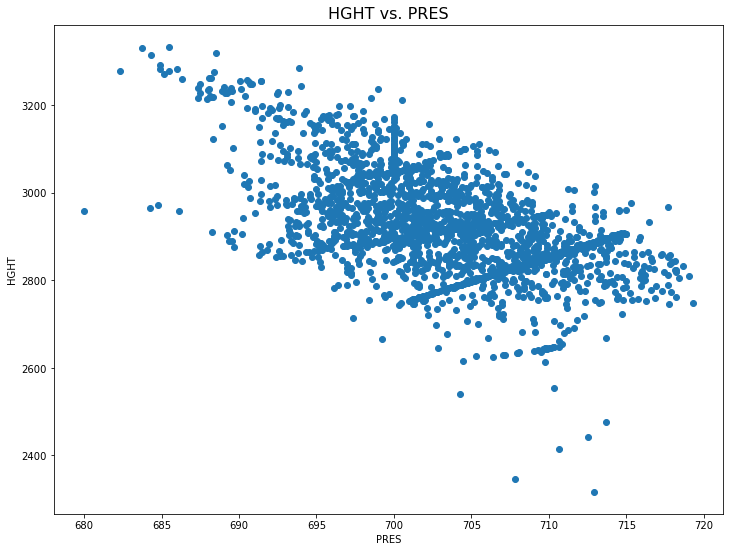

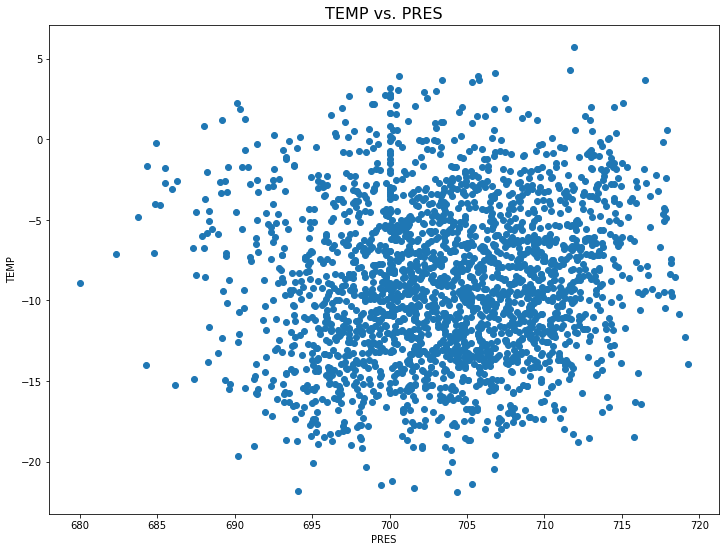

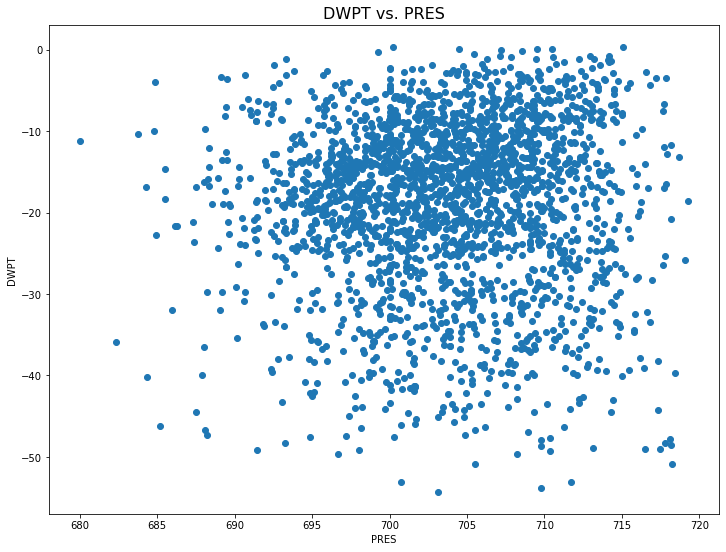

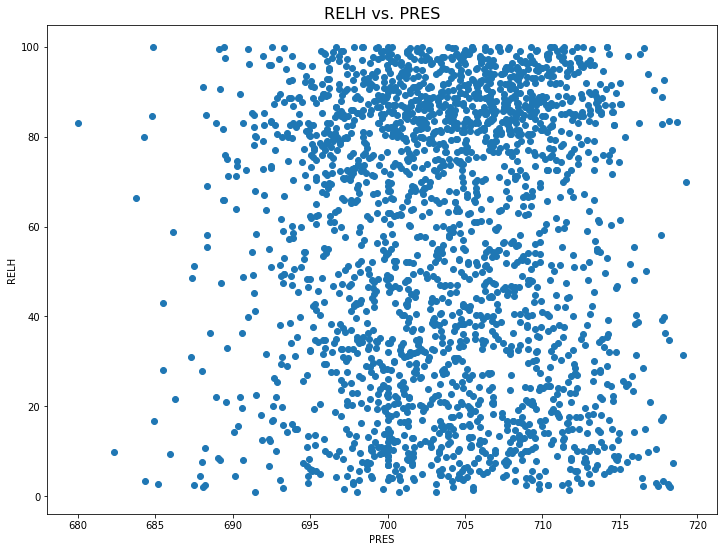

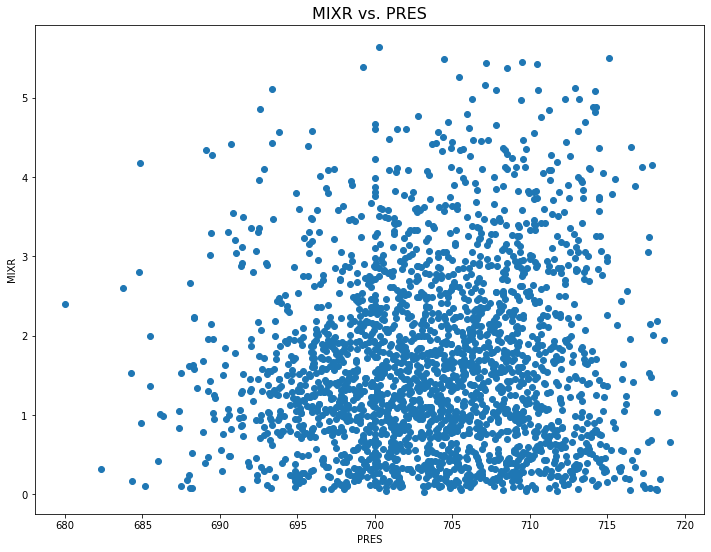

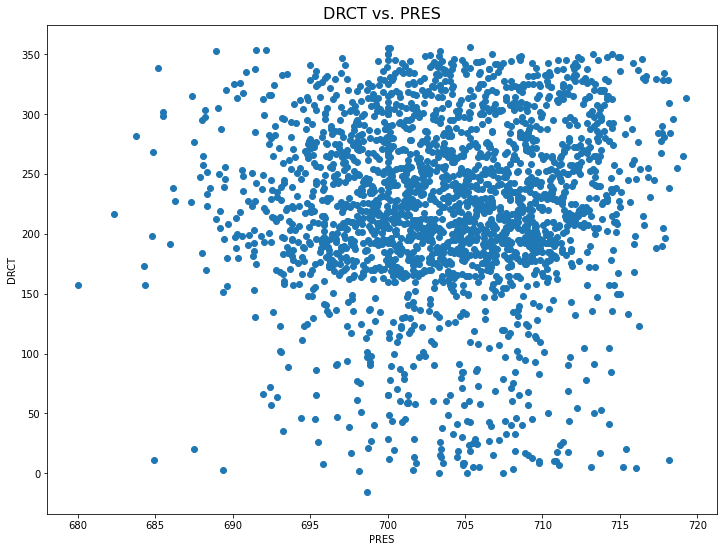

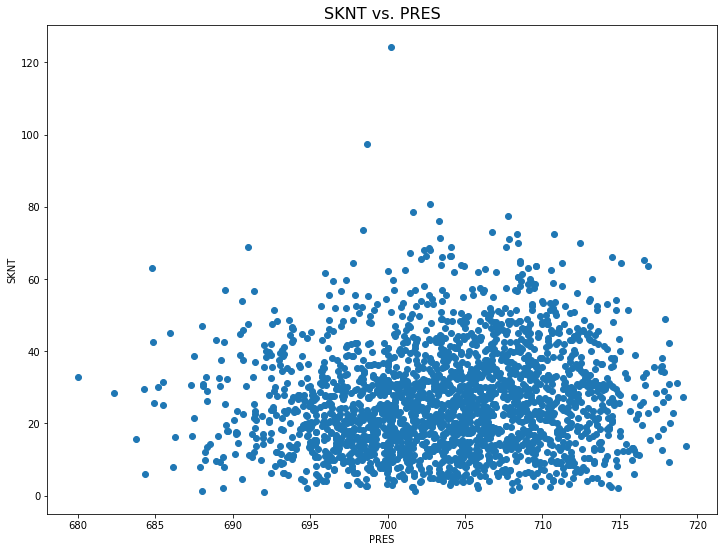

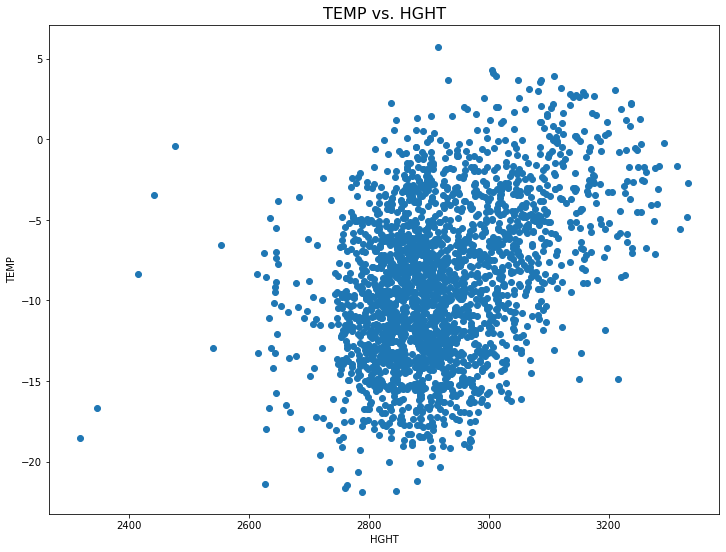

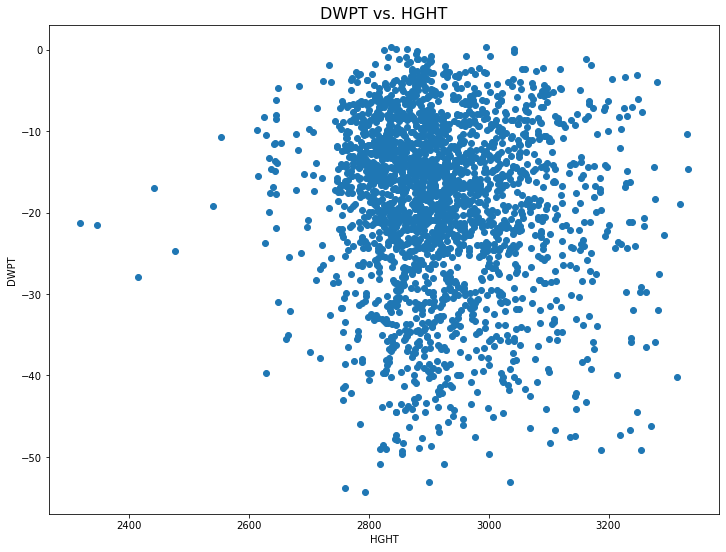

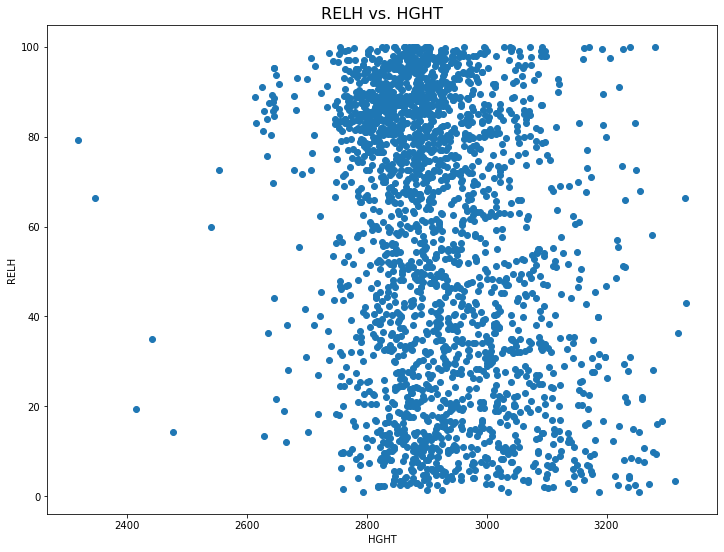

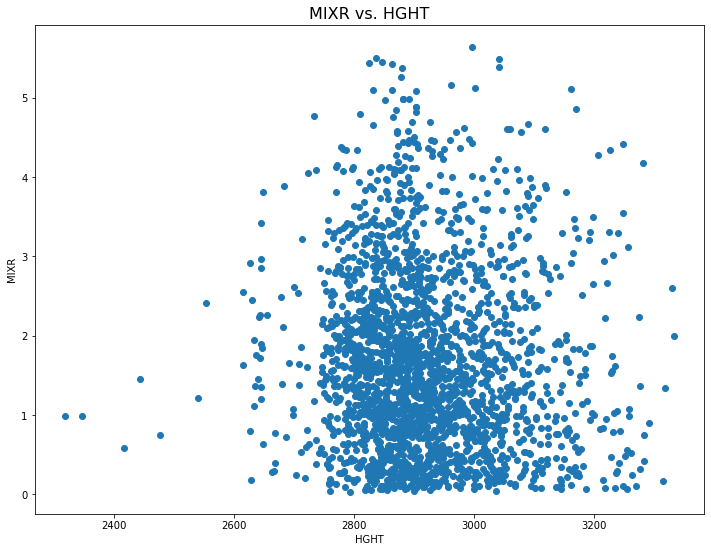

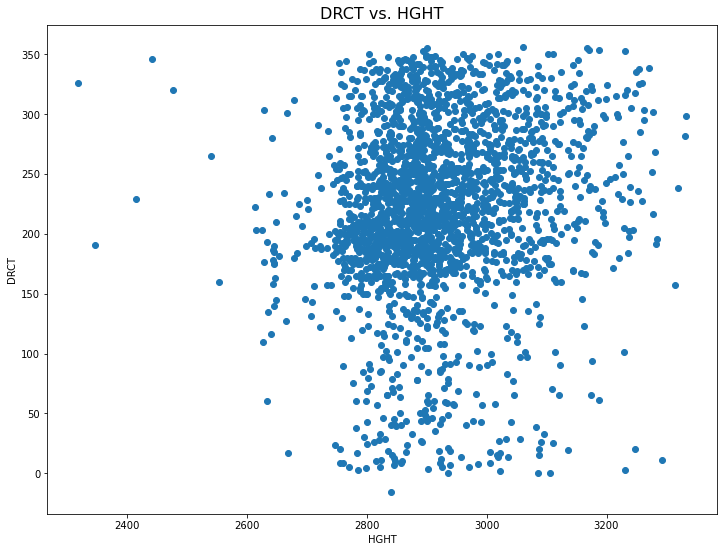

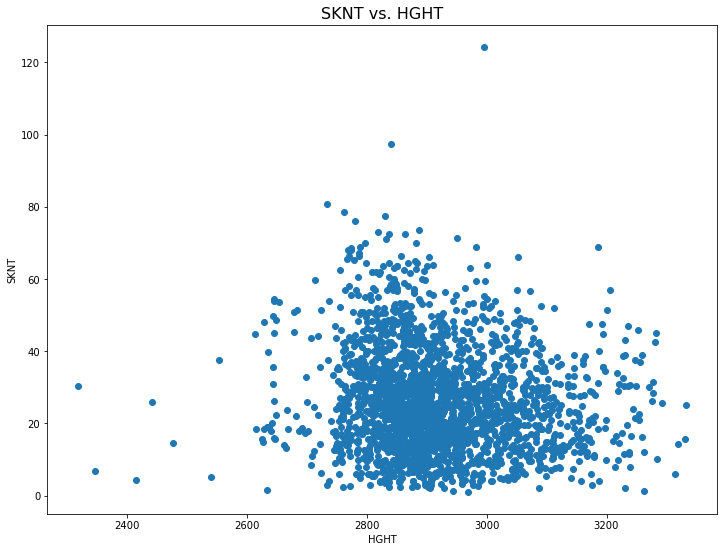

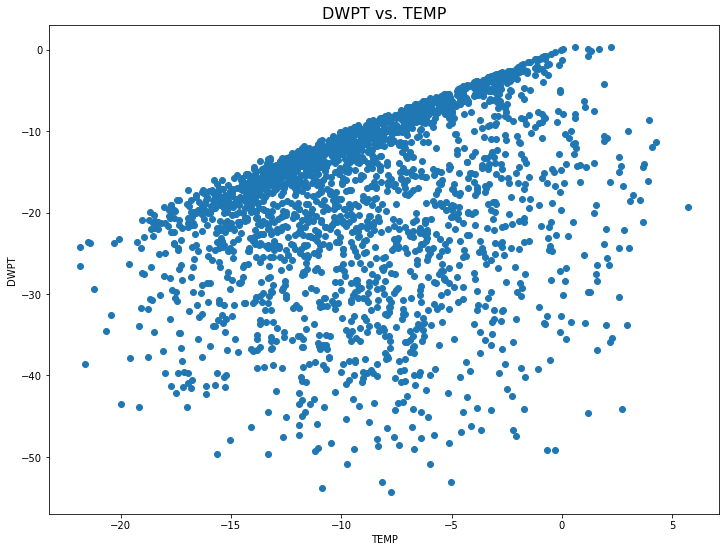

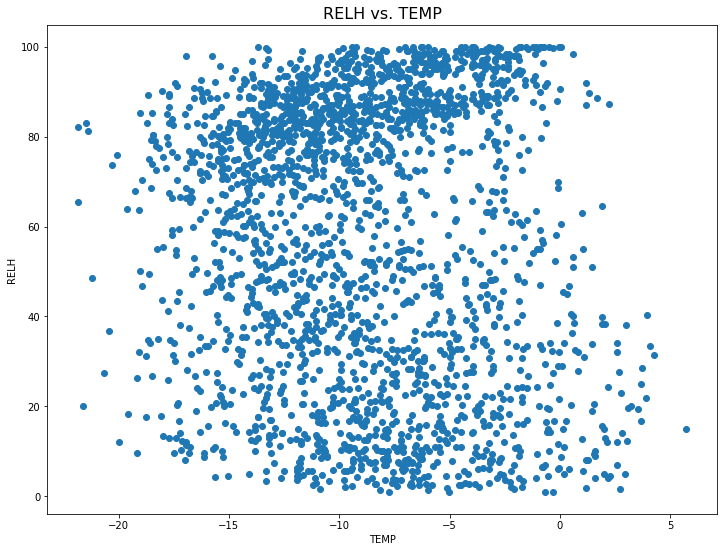

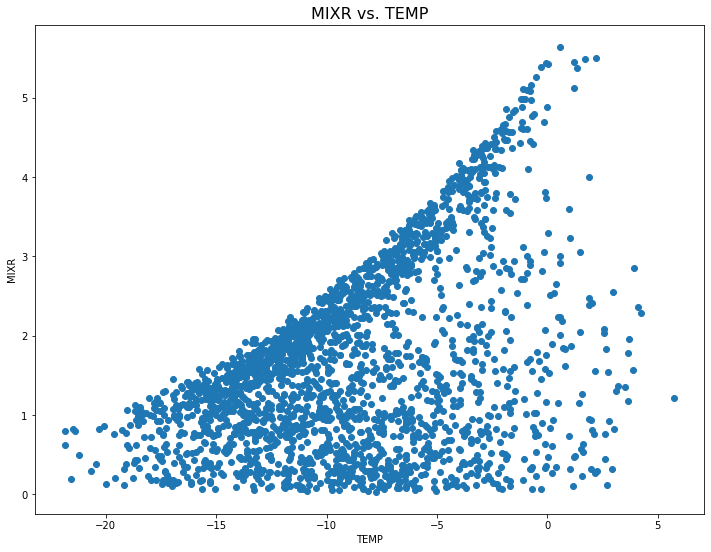

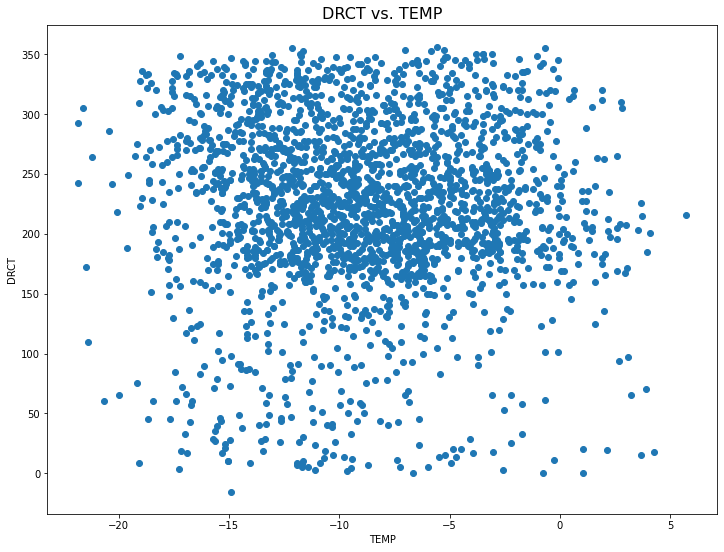

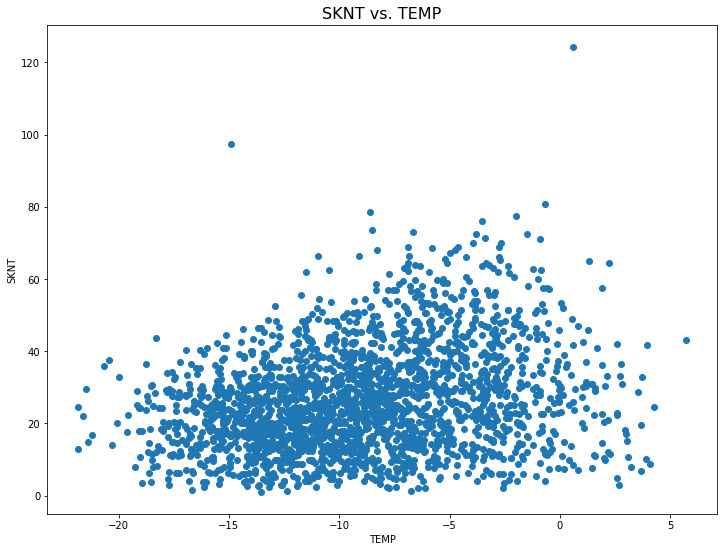

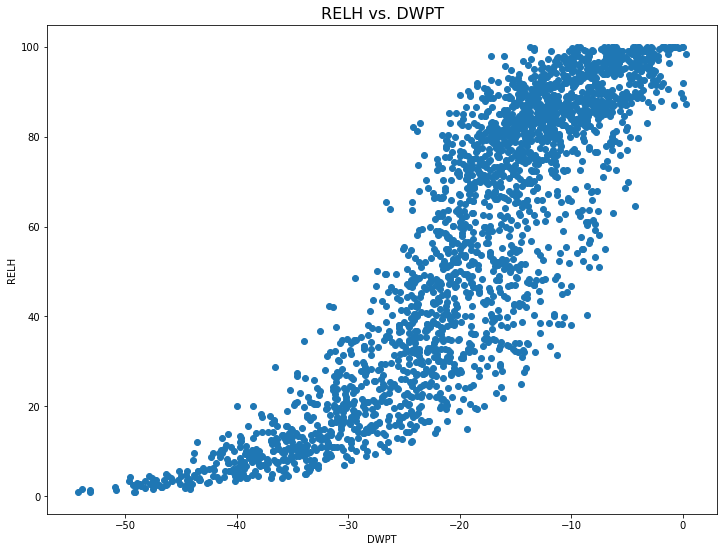

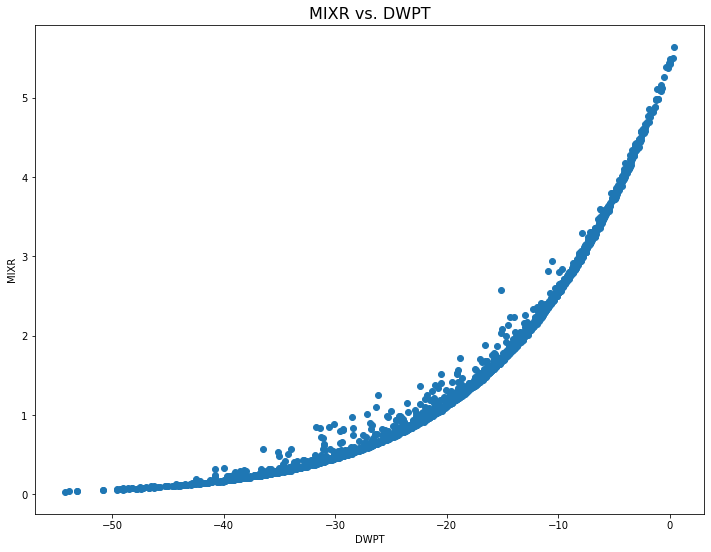

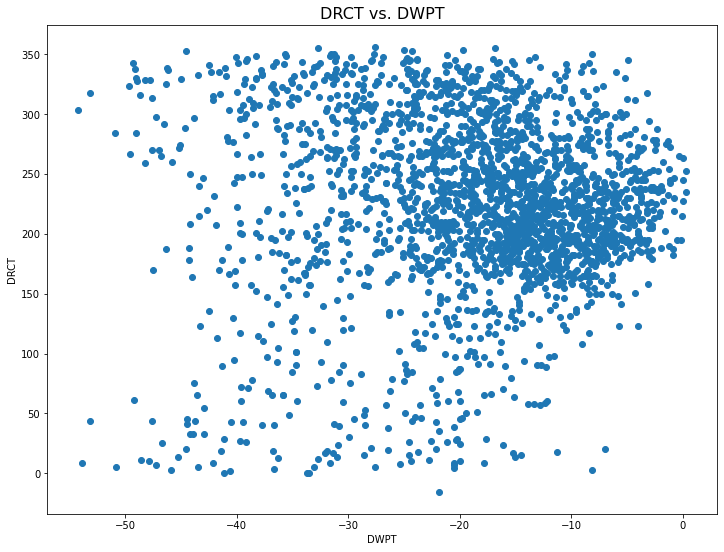

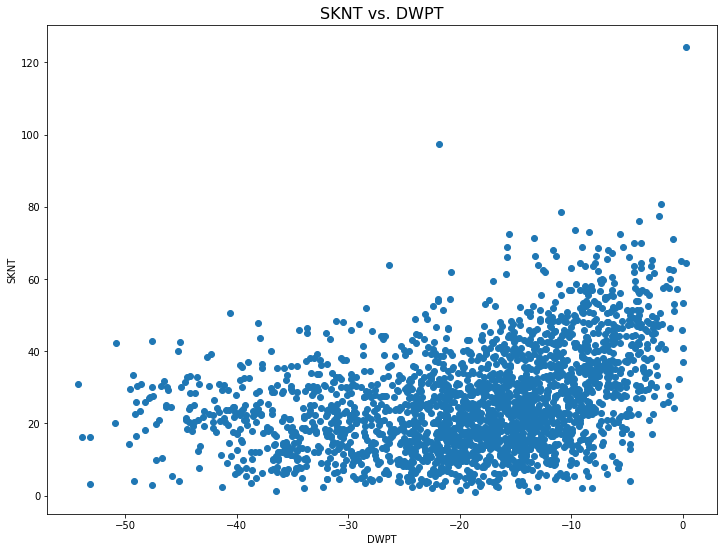

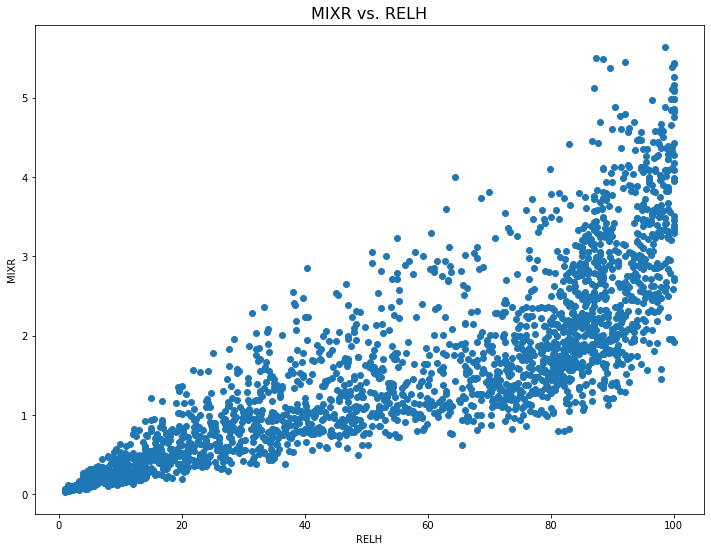

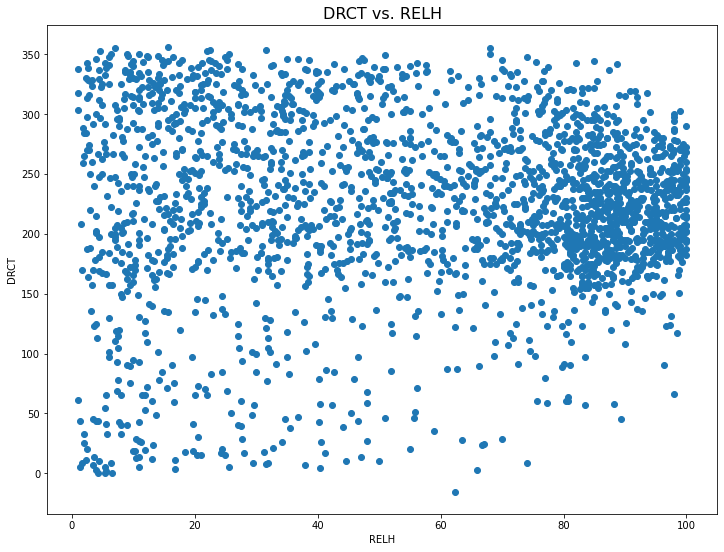

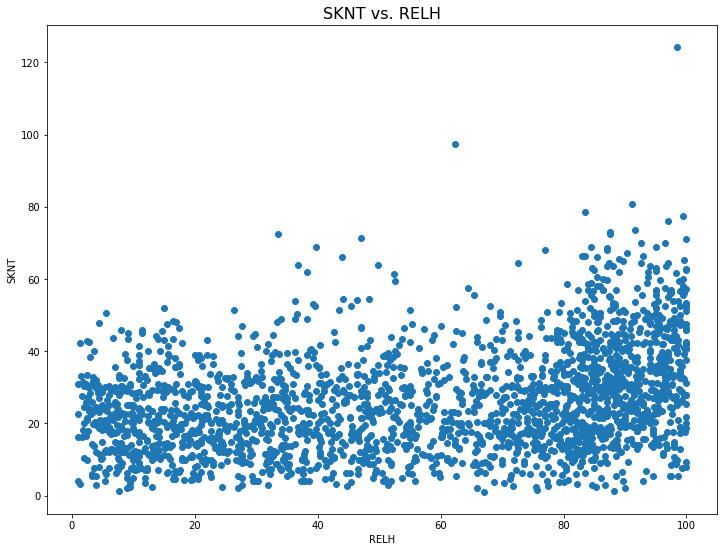

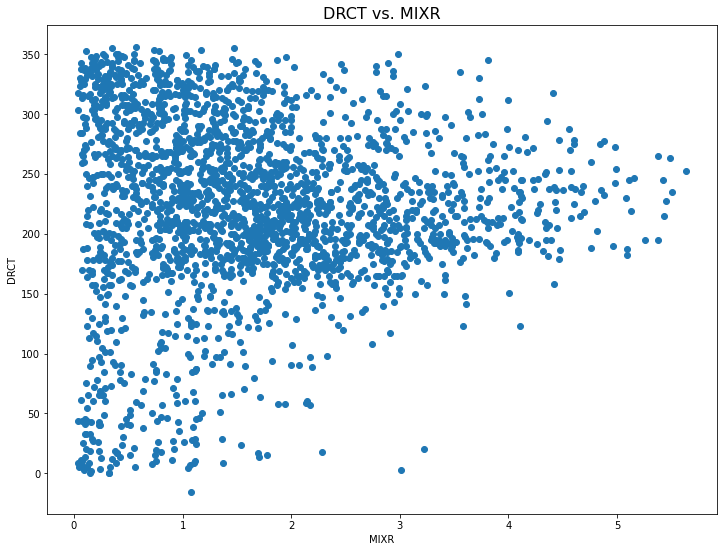

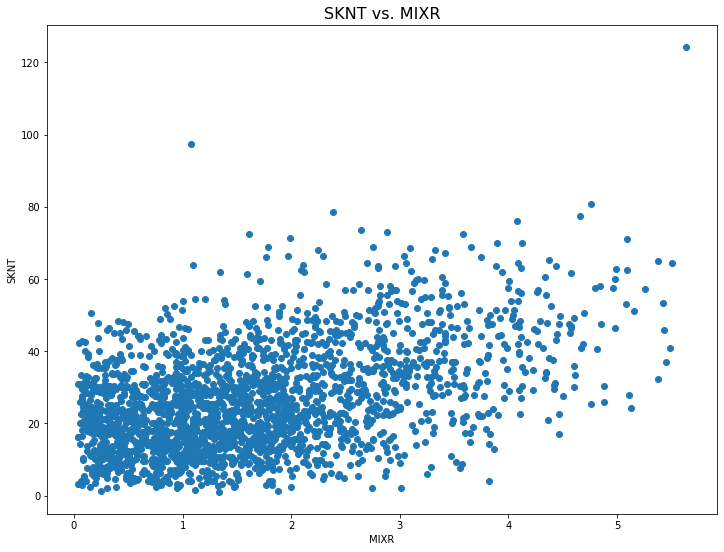

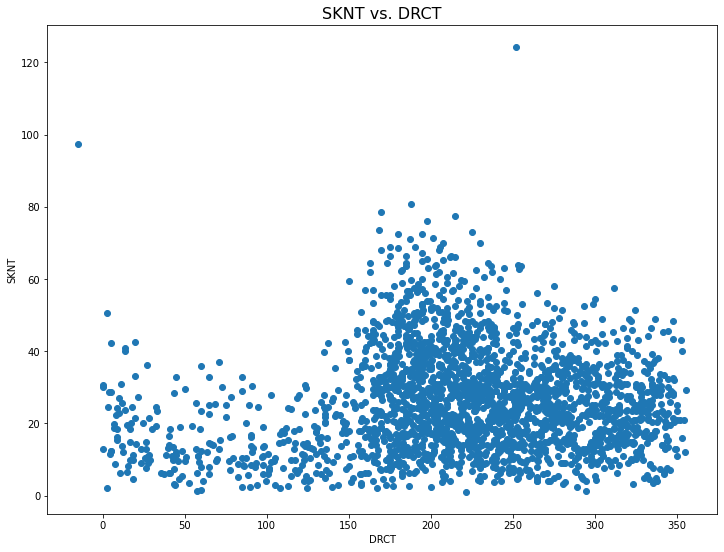

In [88]:
# get two list of columns
columns_x = list(ph_df5.columns)
columns_y = list(ph_df5.columns)

# lose the first element of the y columns so we don't plot first element against first element
columns_y.pop(0)

# loop through x columns
for x_col in columns_x:
    
    # loop through y columns and plot scatter plots
    for y_col in columns_y:
        plt.figure(figsize = (12,9))
        plt.scatter(ph_df5[x_col], ph_df5[y_col])
        plt.title(f"{y_col} vs. {x_col}",
                  size = '16')
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.show()
    
    # remove the first element of y-cols so we don't duplicate anything
    columns_y.pop(0)
    
    # prevent error at end
    if len(columns_y) == 0:
        break

From the above scatter plots, we can see that it is going to be very difficult to try and impute values into our series via some sort of regression.  The simple fact is that predicting weather is far outside the scope of this project.  At this point, we are going to drop all remaining rows with NaN values and export a clean csv file.  We will see how the modelling goes and return to this point if needed further down the line.

In [89]:
missing_records_df.shape

(7, 10)

In [90]:
# export to csv - be sure to include index as it is our time!
ph_df5.to_csv('./Data/PortHardyClean.csv')